##  6、PyTorch框架

本节我们使用学术界用的比较多的PyTorch框架基于CIFAR-10数据集进行模型的训练。PyTorch 安装请参考官方手册[PyTorch START LOCALLY](https://pytorch.org/get-started/locally/)，根据所用的环境选择对应的安装方式。

PyTorch模型构建有低、中、高3个层次的API：

1. 低阶API，主要包括张量操作，在低阶API层次上，可以把Pytorch当做一个增强版的numpy来使用。Pytorch提供的方法比numpy更全面。低阶API同前面我们自己实现的各种前向计算、反向计算函，区别是pytorch都已经实现好了，主要在torch.nn.functional模块中。低阶API构建模型的方法不做详细介绍。

2. 中阶API，基于`nn.Module`构建模型并完成训练。

3. 高阶API，基于`nn.Sequential`构建模型并完成训练。


三个不同层次的API在灵活性和便利性上面有以下特点：

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |



In [2]:
# 本节用到的pytorch包，框架名是pytorch，包名是torch
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

如果要用GPU，确保所在的环境有GPU并且安装了合适的GPU的驱动和CUDA版本，并修改USE_GPU=True，再执行以下代码。

In [3]:
USE_GPU = False
dtype = torch.float32 # 数据类型全部使用float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


### 6.1 CIFAR10数据集

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html )，总共有60000张标注好的32*32大小的彩色图片，总共10个类别，每个类别6000张。其中50000张训练集，10000张测试集，分成5个training batches和一个test batch文件，每个batch文件包含10000张图片。

点击[python version](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)下载CIFAR-10的python版本，下载下来是tar.gz压缩包，解压到cifar-10-batches-py目录，会看到data_batch1~data_batch5 五个训练集文件和一个test_batch测试集文件。

In [4]:
# 使用shell脚本下载CIFAR10数据文件，有160多MB，下载时间跟网络状况有关
# 如有warning可执行：sudo apt install python3-pickleshare
# windows下不支持shell脚本运行，可参照get_datasets.sh中的命令手动下载数据到指定目录并解压
%cd src/dataset/
!bash get_datasets.sh
%cd ../../

/home/wangfiox/ai-hitsz/lab2/src/dataset
--2025-05-04 20:43:09--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... ::ffff:198.18.0.46, 198.18.0.46
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|::ffff:198.18.0.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar  99%[==================> ] 161.73M  1.80MB/s    in 75s     

2025-05-04 20:44:25 (2.16 MB/s) - Connection closed at byte 169582206. Retrying.

--2025-05-04 20:44:26--  (try: 2)  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|::ffff:198.18.0.46|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 170498071 (163M), 915865 (894K) remaining [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar  99%[+++++++++++++++++++ ] 162.59M  90.8K

In [8]:
# Load the raw CIFAR-10 data.
from src.util import load_CIFAR10,download_CIFAR10

cifar10_root = 'src/dataset/'
cifar10_dir = cifar10_root + 'cifar-10-batches-py'
# download_CIFAR10(cifar10_root)

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


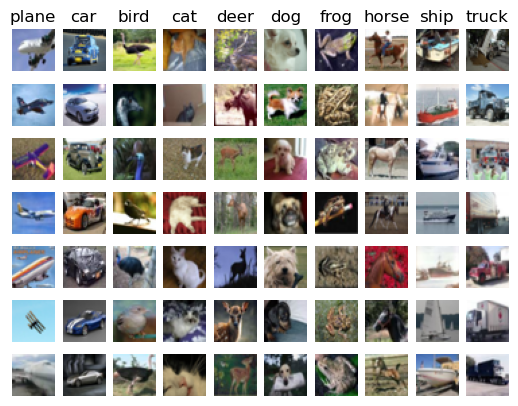

In [9]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
import matplotlib.pyplot as plt
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

CIFAR10是一个比较经典的数据集，PyTorch提供非常便利的工具用于加载和各种预处理。CIFAR10是彩色图片，模型的训练难度比MNIST大。训练过程中将CIFAR-10的训练集拿了1000张出来做验证集，验证集用于验证和挑选合适的超参数，可以在模型训练过程中反复被用到，而测试集只应该被使用一次。

以下代码块用pytorch自带的加载工具加载CIFAR10并划分成了训练集、验证集和测试集。

In [10]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./src/dataset', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./src/dataset', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./src/dataset', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

### 6.2 Module API

这一小节介绍使用Module API分别实现一个2层全连接网络和3层卷积网络的定义和训练。

使用Module API构建模型的步骤如下:

1. 定义一个新的模型类继承自 `nn.Module`，新的类名要能直观地提现模型的结构如 `TwoLayerFC`。

2. 在构造函数 `__init__()`中定义所有的层，模型层直接用PyTorch提供的 `nn.Linear`、 `nn.Conv2d`等常用层, 只需传入层的超参数，层的权重会自动生成。记得要先调用 `super().__init__()` 函数。

3. 实现模型的 `forward()` 方法, 描述模型的前向计算是怎么执行的，也决定了模型中各层的连接关系。

PyTorch内置的层可以查阅手册[builtin layers doc](http://pytorch.org/docs/master/nn.html) 。
定义好模型类后，就可以实例化模型。以下是使用Module API构建2层全连接网络的例子：

In [11]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


使用Module API构建卷积网络的过程同上，以3层的卷积模型为例，模型结构如下：

1. 卷积层1： `channel_1`个输出通道， 5x5 大小， 零填充，填充大小是2
2. ReLU激活
3. 卷积层2： `channel_2`个输出通道，3x3 大小，零填充，填充大小是1
4. ReLU激活
5. 全连接层：`num_classes`个输出

不需要显式定义softmax层，交叉熵损失函数cross_entropy会自动做softmax处理。实现3层卷积网络之后, 执行`test_ThreeLayerConvNet` 会输出scores的大小 `(64, 10)` .

In [12]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        # http://pytorch.org/docs/stable/nn.html#conv2d
        self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        scores = None

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        scores = self.fc(flatten(x))
        
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


下面块的`check_accuracy()`方法计算模型在指定数据集上的准确率，执行的是前向计算，无需累积梯度，所以在torch.no_grad()环境下执行，不做反向计算，不保留梯度。

[torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html)是一个禁止梯度计算的上下文管理器，调用torch.no_grad()后，变量的requires_grad属性会设置为False，会减少内存消耗，减少反向传播的计算。

[model.eval()](https://pytorch.org/docs/stable/notes/autograd.html#evaluation-mode-nn-module-eval)只对特定的层有作用如Dropout, BatchNorm，eval模式是不启用这些层，如果没有这些层，model.eval()和model.train()没有任何区别。model.eval()跟梯度计算是没有关系的，不要与torch.no_grad()的作用弄混。

详细可参考：

1. [Evaluating pytorch models: `with torch.no_grad` vs `model.eval()`](https://stackoverflow.com/questions/55627780/evaluating-pytorch-models-with-torch-no-grad-vs-model-eval)

2. [PyTorch AUTOGRAD MECHANICS](https://pytorch.org/docs/stable/notes/autograd.html)

In [13]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

`train_model()`方法进行模型的训练：计算损失、反向传播求梯度、使用优化算法（优化器）更新模型权重。参数optimizer指定权重优化方法，除了随机梯度下降（SGD）外还有Momentum、Adam等方法，pytorch优化器的实现在`torch.optim`包中。

In [14]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print_every = 200
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("Epochs :", e)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

这里以2层的全连接网络TwoLayerFC训练为例：
1. 定义模型TwoLayerFC，只需要传入输入数据大小、hidden_layer_size、分类类别数
2. 使用SGD优化器
3. 调用train_model进行模型训练，训练一个epoch之后预计可以达到40%的准确率。

In [15]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_model(model, optimizer)

Epochs : 0
Iteration 0, loss = 3.3044
Checking accuracy on validation set
Got 130 / 1000 correct (13.00)



KeyboardInterrupt: 

卷积神经网络的训练跟TwoLayerFC训练过程一样，训练一个epoch之后预计可以达到45%的准确率。

In [ ]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_model(model, optimizer)

上面代码有`loss.backward()`等操作涉及到自动求导，Pytorch的自动求导由autograd包实现。下面代码展示了PyTorch简单的求导的应用，计算结果跟前面我们自行实现sigmoid结果一致。

In [ ]:
# 对标量求导
x1=torch.tensor(1.0, requires_grad=True)
torch_sigmoid = torch.nn.Sigmoid()
y = torch_sigmoid(x1)
y.backward()
print('x1 grad:', x1.grad)

# 对向量求导
x2 = torch.tensor([-1.0, 1.0, 2.0], requires_grad=True)
torch_sigmoid = torch.nn.Sigmoid()
y = torch_sigmoid(x2)
y.backward(torch.ones(x2.shape))  #或者通过y.sum().backward()求导。
print('x2 grad:', x2.grad)

## 6.3 Sequential API

对于简单的模型比如前馈神经网络，使用`nn.Module` API定义模型仍然需要3步：定义新的模型类、在构造函数`__init__`中定义层、在`forward()`方法中调用每个层。

PyTorch提供了一个容器类`nn.Sequential`可以将以上3步合成一步，更加方便，但没有`nn.Module`灵活，如果要定义一个复杂的网络结构则不可行，但`nn.Sequential`覆盖了大部分的场景，尤其是简单堆叠的前馈神经网络。

下面使用`nn.Sequential`重新定义Two-Layer Network并完成训练，利用变长参数按层顺序构建即可，模型层按照定义的顺序添加，非常直观。 另外接受OrderedDict参数进行模型定义。如果模型已经定义好了，还可通过add_module继续添加层。

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_model(model, optimizer)

下面使用`nn.Sequential`重新定义3层卷积神经网络并完成训练。

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

train_model(model, optimizer)

## 6.4 自主设计网络

下面请自主实现一个神经网络，在CIFAR-10数据集上完成训练，可以使用任意的模型结构、超参数、损失函数和优化器等，要求在训练10个epoch内在验证集上至少达到70%的准确率。可以使用经典的模型，但不能直接使用modelzoo中定义好的或者训练好的模型。 

可能需要参考的资料：

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html
* API doc: http://pytorch.org/docs/stable/index.html
* PyTorch discuss: https://discuss.pytorch.org/
* tutorial: https://github.com/jcjohnson/pytorch-examples

训练集上完成训练后，最后在测试集上进行测试，注意测试集只能用一次，用于模型最后的泛化能力评估。

In [ ]:
best_model = model
check_accuracy(loader_test, best_model)

本节要完成的内容：
1. 安装PyTorch，运行以上代码，熟悉PyTorch的基础使用
2. 自定义一个模型实现CIFAR10分类，使用PyTorch完成训练，要求10个epoch内能在验证集上至少达到70%的准确率。
3. 在实验报告中，分别给出本节用到的两层全连接网络、三层卷积网络、自定义网络的参数量，使用model.parameters()、model.named_parameters()、model.state_dict()或者[pytorch-summary](https://github.com/sksq96/pytorch-summary)等工具进行结果验证。

主要参考：
1. cs231n: http://cs231n.stanford.edu/
2. 《深度学习入门：基于Python的理论与实现》斋藤康毅著